## Retail Store Sales Forecasting with Neural Networks - Exploratory Data Analysis (EDA)
## By Yasaman Ensafi - 500913843
### Ryerson Data Science and Analytics (MSc)
#### 2019

## Import libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams

## Load Dataset

In [17]:
data= pd.read_excel('Sample_Superstore.xls')

## EDA

In [18]:
data.head(n=2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [19]:
data.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


## Missing Data

In [20]:
data.info()
# We can see that there is no missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
Row ID           9994 non-null int64
Order ID         9994 non-null object
Order Date       9994 non-null datetime64[ns]
Ship Date        9994 non-null datetime64[ns]
Ship Mode        9994 non-null object
Customer ID      9994 non-null object
Customer Name    9994 non-null object
Segment          9994 non-null object
Country          9994 non-null object
City             9994 non-null object
State            9994 non-null object
Postal Code      9994 non-null int64
Region           9994 non-null object
Product ID       9994 non-null object
Category         9994 non-null object
Sub-Category     9994 non-null object
Product Name     9994 non-null object
Sales            9994 non-null float64
Quantity         9994 non-null int64
Discount         9994 non-null float64
Profit           9994 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(3), object(13)
memory usage: 1.6+ 

In [21]:
#Shape
data.shape

(9994, 21)

In [23]:
data.columns

Index(['Row_ID', 'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode',
       'Customer_ID', 'Customer_Name', 'Segment', 'Country', 'City', 'State',
       'Postal_Code', 'Region', 'Product_ID', 'Category', 'Sub-Category',
       'Product_Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

## Edit columns names

In [30]:
# Lower case column names
data.columns = map(str.lower, df.columns)
#Replace spaces with '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

## Observe the contents of each column

In [31]:
print("Unique row_id:",len(set(data["row_id"])))
print("Unique order_id:",len(set(data["order_id"])))
print("Unique ship_mode:",set(data["ship_mode"]))
print("Unique customer_id:",len(set(data["customer_id"])))
print("Unique customer_name:",len(set(data["customer_name"])))
print("Unique segment:",set(data["segment"]))
print("Unique country:",set(data["country"]))
print("Unique city:",len(set(data["city"])))
print("Unique state:",len(set(data["state"])))
print("Unique region:",set(data["region"]))
print("Unique category:",set(data["category"]))
print("Unique sub_category:",len(set(data["sub_category"])))
print("Unique product_id:",len(set(data["product_id"])))
print("Unique product_name:",len(set(data["product_name"])))
print("Sales mean:",np.round(np.mean(data["sales"]),2))
print("Quantity mean:",np.round(np.mean(data["quantity"]),2))
print("Discount mean:",np.round(np.mean(data["discount"]),2))
print("Profit mean:",np.round(np.mean(data["profit"]),2))

Unique row_id: 9994
Unique order_id: 5009
Unique ship_mode: {'Standard Class', 'First Class', 'Second Class', 'Same Day'}
Unique customer_id: 793
Unique customer_name: 793
Unique segment: {'Consumer', 'Corporate', 'Home Office'}
Unique country: {'United States'}
Unique city: 531
Unique state: 49
Unique region: {'South', 'East', 'West', 'Central'}
Unique category: {'Technology', 'Office Supplies', 'Furniture'}
Unique sub_category: 17
Unique product_id: 1862
Unique product_name: 1850
Sales mean: 229.86
Quantity mean: 3.79
Discount mean: 0.16
Profit mean: 28.66


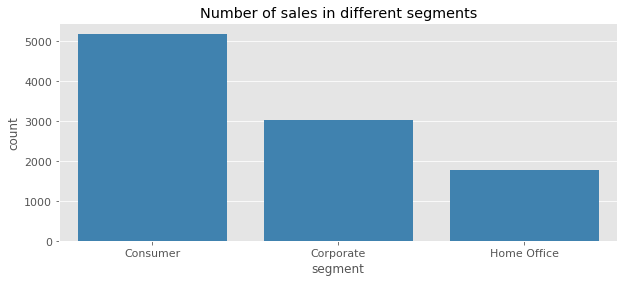

In [32]:
plt.figure(figsize = (10,4))
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11) 
sns.countplot(df['segment'],color='#2E86C1')
plt.title("Number of sales in different segments")
plt.show()

In the above bar chart we can see the number of sales in different segments. Most of the buyers belong to Consumer segment. 

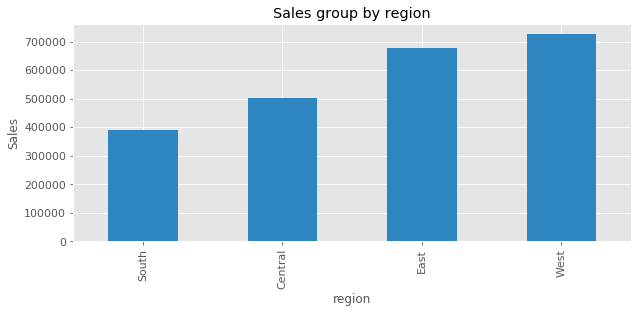

In [41]:
ax=plt.figure(figsize=(10,4))
data.groupby('region')['sales'].sum().sort_values().plot('bar',color='#2E86C1')
plt.title("Sales group by region")
plt.ylabel("Sales")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In the above left bar chart, we want to find the location of retail store with highest amount of sold items. So by generating a bar chart, we can conclude that western states have sold more than 700000 dollars. Also eastern states have second highest sales amount which is more than 600000 dollars. In the above right bar chart the amount of sold items group by region is plotted. We can see that retail stores located in west of US sold more than 12000. On the other hand ratil stores located in south of US sold near 6000 items which is less than other regions. 

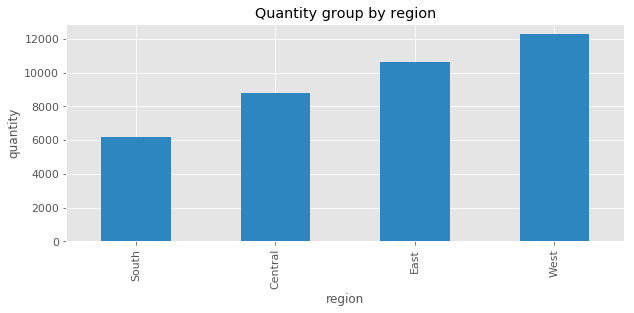

In [42]:
ax=plt.figure(figsize=(10,4))
data.groupby('region')['quantity'].sum().sort_values().plot('bar',color='#2E86C1')
plt.title("Quantity group by region")
plt.ylabel("quantity")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Next two graphs represent the amount of sold items and the number of sold items in different states. In both of these graphs, the states with highest amount and number of sold items are California, New York and Texas respectively.

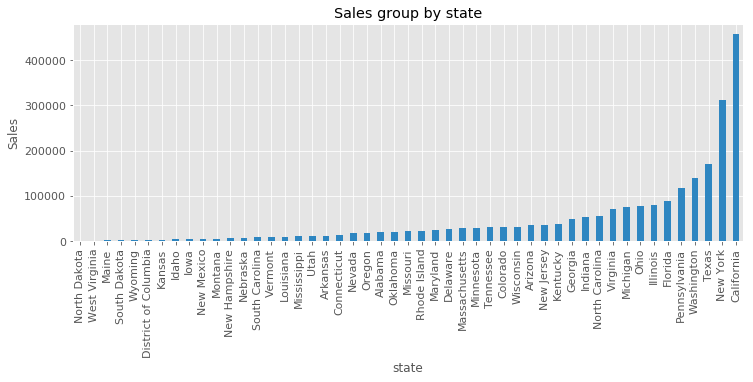

In [43]:
ax=plt.figure(figsize=(12,4))
data.groupby('state')['sales'].sum().sort_values().plot('bar',color='#2E86C1')
plt.title("Sales group by state")
plt.ylabel("Sales")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

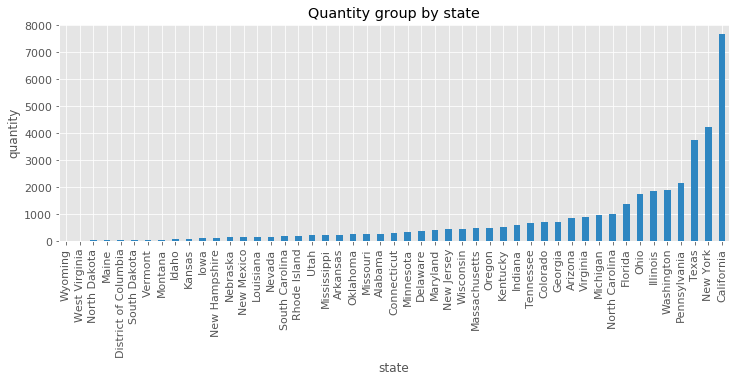

In [44]:
ax=plt.figure(figsize=(12,4))
data.groupby('state')['quantity'].sum().sort_values().plot('bar',color='#2E86C1')
plt.title("Quantity group by state")
plt.ylabel("quantity")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

The next graph illustrates the amount of profit group by state. California and New York gained the highest profit amount. On the other hand, Texas and Ohio have the highest negative profit among all states. The reason for this matter can be explained in the diagram after that. As we can see, Texas has the second highest average amount of discount on its sold items among other states.

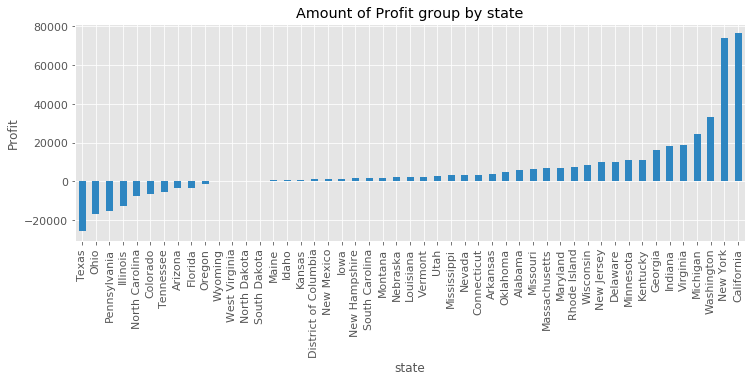

In [45]:
ax=plt.figure(figsize=(12,4))
data.groupby('state')['profit'].sum().sort_values().plot('bar',color='#2E86C1')
plt.ticklabel_format(style='plain', axis='y')
plt.title("Amount of Profit group by state")
plt.ylabel("Profit")
plt.show()

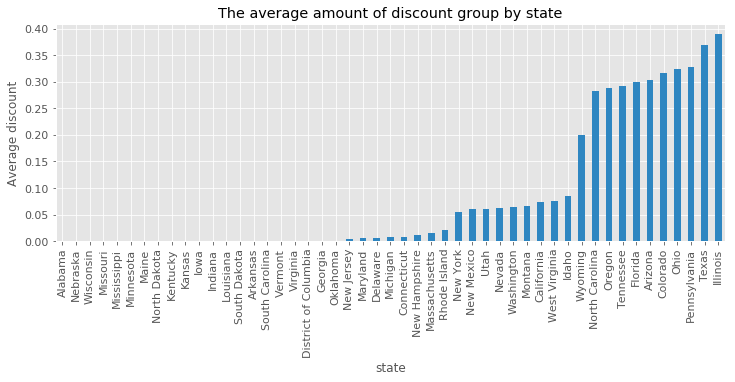

In [46]:
ax=plt.figure(figsize=(12,4))
data.groupby('state')['discount'].mean().sort_values().plot('bar',color='#2E86C1')
plt.ticklabel_format(style='plain', axis='y')
plt.title("The average amount of discount group by state")
plt.ylabel("Average discount")
plt.show()

The graph below shows the number of sales group by region separated by category. In all of the regions products in office supplies category were the bes seller and products in the furniture category sold less than others.

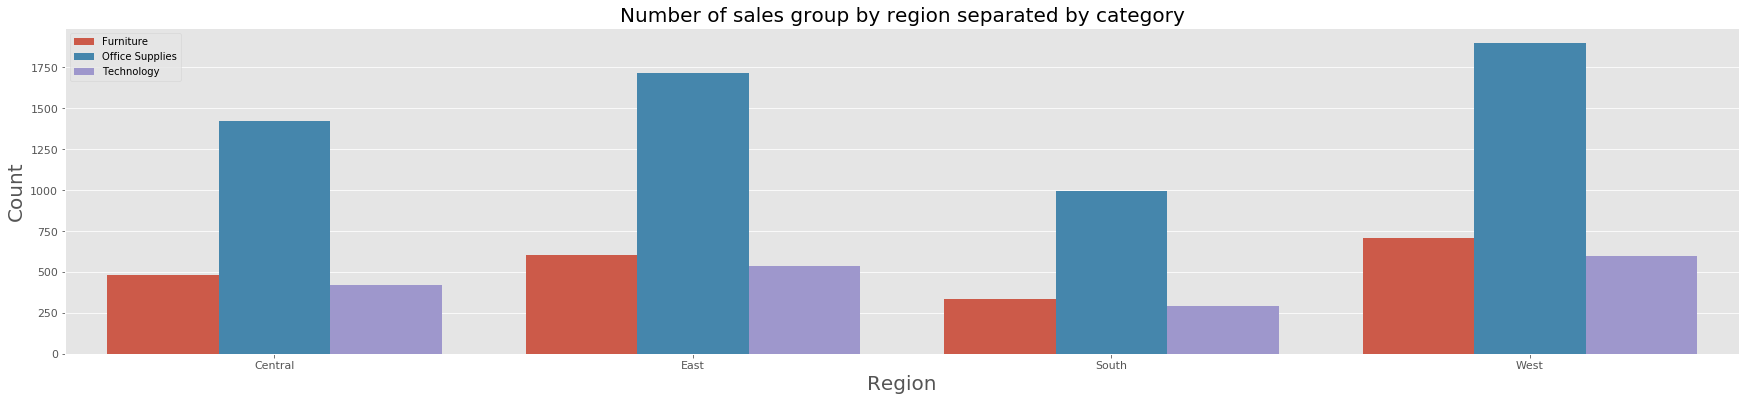

In [48]:
plt.figure(figsize = (30,6))
sns.countplot(data.sort_values(by=['region'])['region'], hue=data["category"])
plt.legend( loc="upper left")
plt.title("Number of sales group by region separated by category", size=20)
plt.ylabel("Count",size=20)
plt.xlabel("Region",size=20)
plt.show()

In the graph below we can see the best seller sub categories in all regions are binders and paper respectively. On the other hand, copiers and machines didn't sell very well.

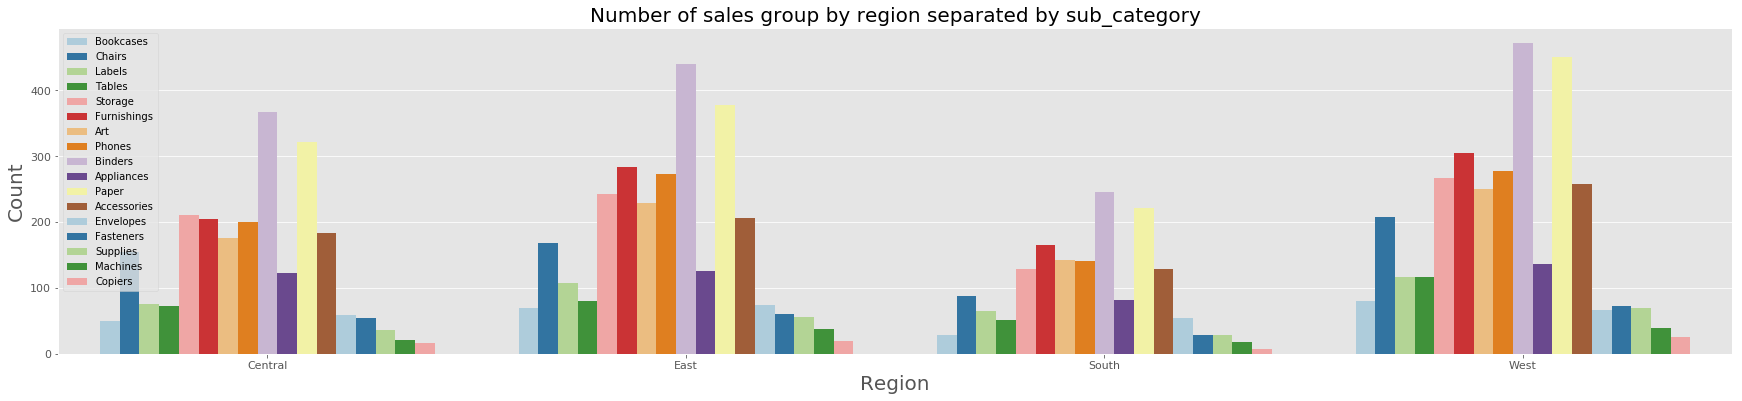

In [49]:
plt.figure(figsize = (30,6))
sns.countplot(data.sort_values(by=['region'])['region'], hue=data["sub_category"],palette='Paired')
plt.legend( loc="upper left")
plt.title("Number of sales group by region separated by sub_category", size=20)
plt.ylabel("Count",size=20)
plt.xlabel("Region",size=20)
plt.show()

From the next graph we can conclude most of sold items had been shipped with standard class. And few of them had been shipped in the same day.

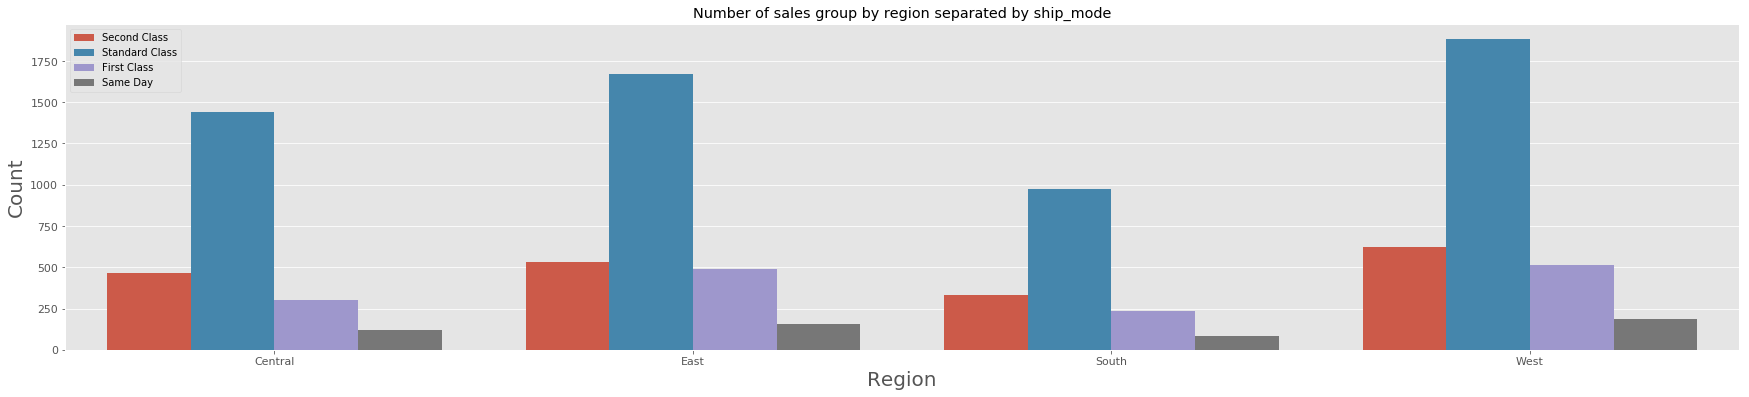

In [50]:
plt.figure(figsize = (30,6))
sns.countplot(data.sort_values(by=['region'])['region'], hue=data["ship_mode"])
plt.legend( loc="upper left")
plt.title("Number of sales group by region separated by ship_mode")
plt.ylabel("Count",size=20)
plt.xlabel("Region",size=20)
plt.show()

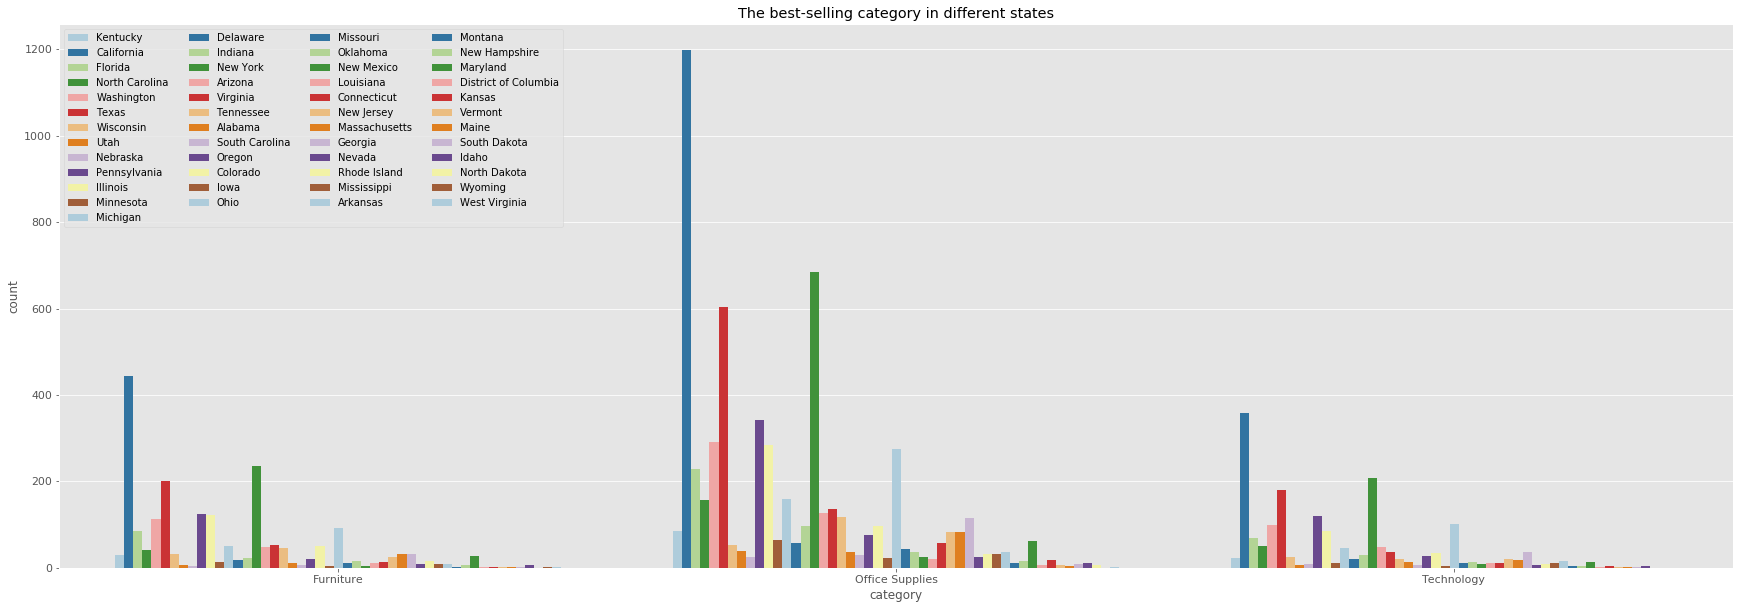

In [51]:
plt.figure(figsize = (30,10))
sns.countplot(data.sort_values(by=['category'])['category'], hue=data["state"],palette='Paired')
plt.legend( loc="upper left" ,ncol=4)
plt.title("The best-selling category in different states")
plt.show()

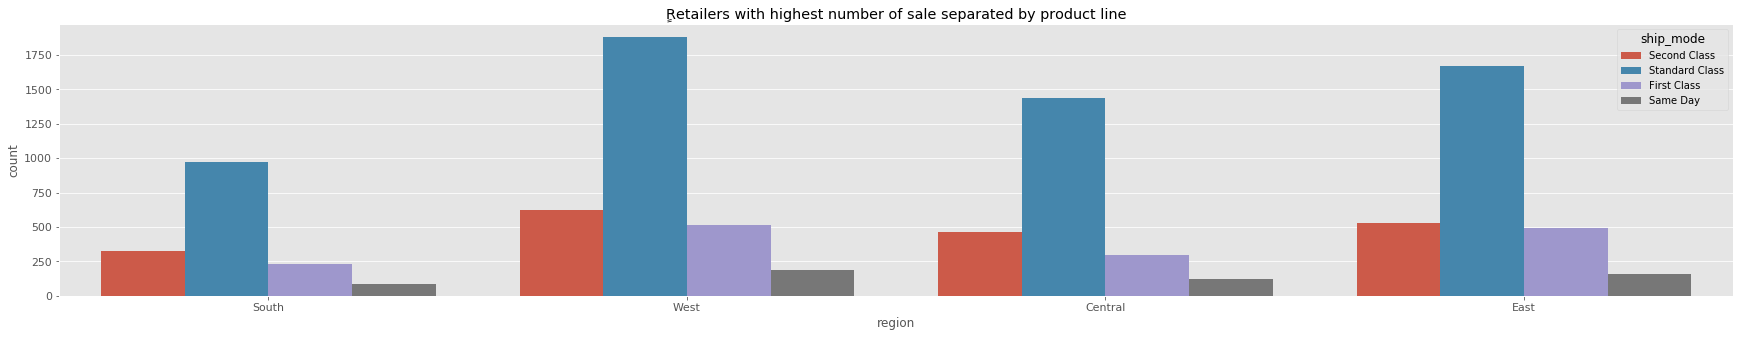

In [52]:
plt.figure(figsize = (30,5))
sns.countplot(data['region'], hue=data["ship_mode"])
plt.title("ٍٍRetailers with highest number of sale separated by product line")
plt.show()

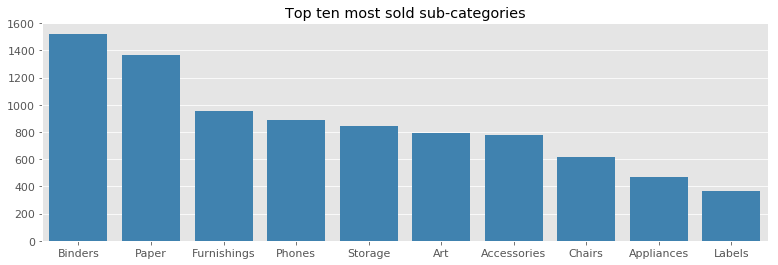

In [53]:
#Top ten most sold sub-categories
plt.figure(figsize=(13,4))
top10 = data['sub_category'].value_counts().sort_values(ascending=False)[:10]
sns.barplot(x=top10.index,y=top10.values,color='#2E86C1')
plt.title("Top ten most sold sub-categories")
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 
plt.show()

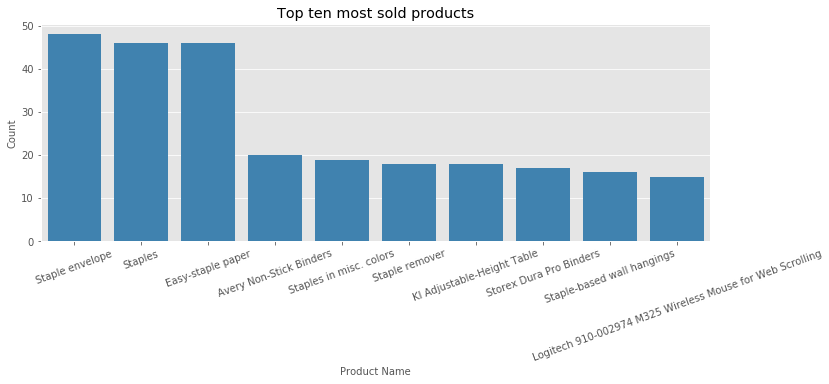

In [54]:
#Top ten most sold items
plt.figure(figsize=(12,4))
top10 = data['product_name'].value_counts().sort_values(ascending=False)[:10]
sns.barplot(x=top10.index,y=top10.values,color='#2E86C1')
plt.title("Top ten most sold products")
plt.ylabel("Count",size=10)
plt.xlabel("Product Name",size=10)
plt.xticks(rotation='20')
plt.show()

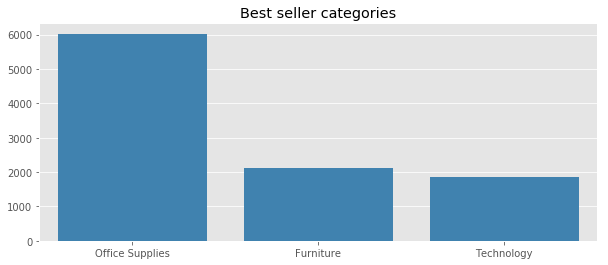

In [55]:
#Top ten most sold items
plt.figure(figsize=(10,4))
top10 = data['category'].value_counts().sort_values(ascending=False)[:10]
sns.barplot(x=top10.index,y=top10.values,color='#2E86C1')
plt.title("Best seller categories")
plt.show()

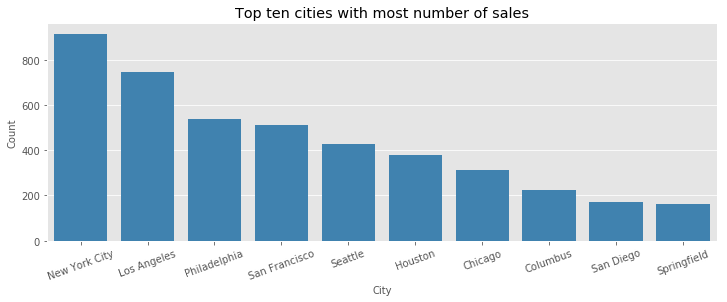

In [56]:
#Top ten most sold items
plt.figure(figsize=(12,4))
top10 = data['city'].value_counts().sort_values(ascending=False)[:10]
sns.barplot(x=top10.index,y=top10.values,color='#2E86C1')
plt.title("Top ten cities with most number of sales")
plt.ylabel("Count",size=10)
plt.xlabel("City",size=10)
plt.xticks(rotation='20')
plt.show()

In [57]:
data.groupby(['state','ship_date']).head(n=5)

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,postal_code,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
6,7,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.2800,4,0.00,1.9656
7,8,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.1520,6,0.20,90.7152
8,9,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.5040,3,0.20,5.7825
9,10,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,114.9000,5,0.00,34.4700


In [58]:
#total quantity of products on this file
data['quantity'].sum()

37873

In [59]:
#Quantity grouped by region
data.groupby(['region'])['quantity'].sum()

region
Central     8780
East       10618
South       6209
West       12266
Name: quantity, dtype: int64

The bellow heat map graph, indicate the positive and negative correlation between variables.
There is a negative correlation between discount and profit. 

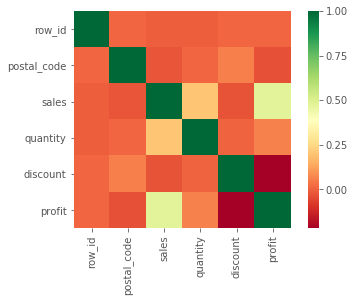

In [60]:
sns.heatmap(data.corr(), square=True, cmap='RdYlGn')

In [61]:
df_furniture=data.loc[data['category'] == 'Furniture']
df_technology=data.loc[data['category'] == 'Technology']
df_office=data.loc[data['category'] == 'Office Supplies']

In [62]:
#Aggregating sales by date
furniture= df_furniture.groupby('order_date')['sales'].sum().reset_index()
technology= df_technology.groupby('order_date')['sales'].sum().reset_index()
office= df_office.groupby('order_date')['sales'].sum().reset_index()

In [63]:
#Set index 
furniture = furniture.set_index('order_date')
technology = technology.set_index('order_date')
office = office.set_index('order_date')

In [64]:
#set index for original datasets
df_furniture = df_furniture.set_index('order_date')
df_technology = df_technology.set_index('order_date')
df_office = df_office.set_index('order_date')

In [65]:
df_furniture.index

DatetimeIndex(['2016-11-08', '2016-11-08', '2015-10-11', '2014-06-09',
               '2014-06-09', '2017-07-16', '2015-09-25', '2015-09-17',
               '2015-09-17', '2016-12-08',
               ...
               '2015-11-13', '2016-06-03', '2016-12-12', '2017-06-01',
               '2015-12-14', '2015-03-19', '2016-12-05', '2015-09-06',
               '2014-01-21', '2017-02-26'],
              dtype='datetime64[ns]', name='order_date', length=2121, freq=None)

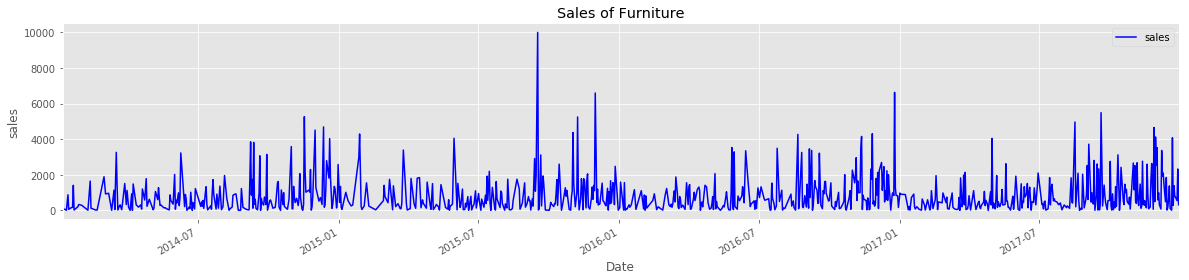

In [69]:
furniture_sales = furniture[['sales']]
ax= furniture_sales.plot(color='blue',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Furniture")
plt.show()

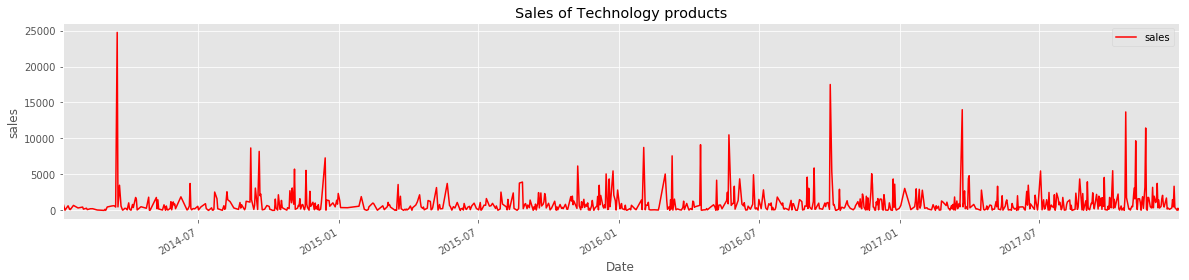

In [70]:
technology_sales = technology[['sales']]
ax= technology_sales.plot(color='r',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Technology products")
plt.show()

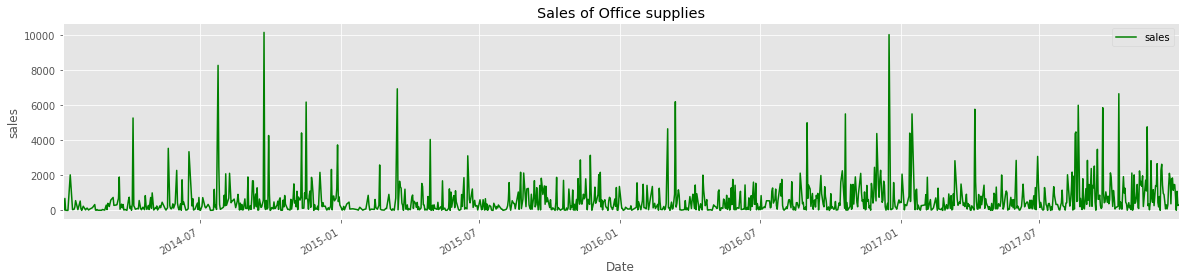

In [71]:
office_sales = office[['sales']]
ax= office_sales.plot(color='green',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Office supplies")
plt.show()

In [74]:
# Using averages daily sales value - set start of the month as index
avg_furniture_sales = furniture_sales['sales'].resample('MS').mean()
avg_technology_sales = technology_sales['sales'].resample('MS').mean()
avg_office_sales = office_sales['sales'].resample('MS').mean()

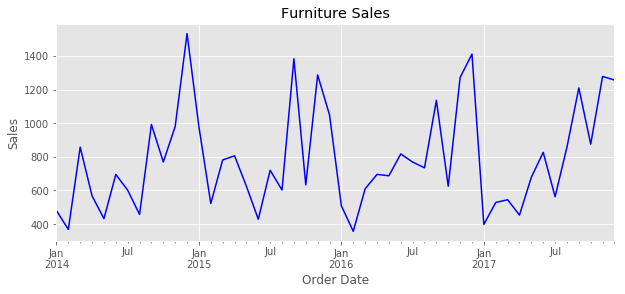

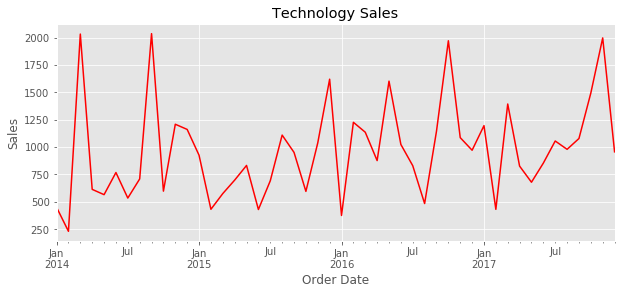

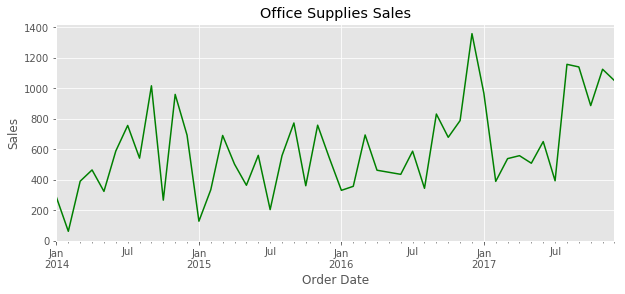

In [75]:
avg_furniture_sales.plot(figsize=(10, 4),color='blue')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Furniture Sales")
plt.show()

avg_technology_sales.plot(figsize=(10, 4),color='red')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Technology Sales")
plt.show()

avg_office_sales.plot(figsize=(10, 4),color='green')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Office Supplies Sales")
plt.show()

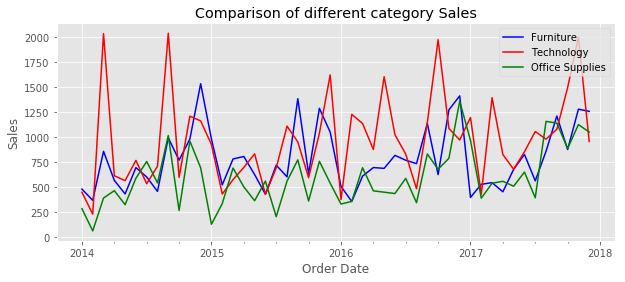

In [259]:
avg_furniture_sales.plot(figsize=(10, 4),color='blue',label = 'Furniture')

avg_technology_sales.plot(figsize=(10, 4),color='red',label = 'Technology')

avg_office_sales.plot(figsize=(10, 4),color='green',label = 'Office Supplies')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Comparison of different category Sales")
plt.legend();
plt.show()

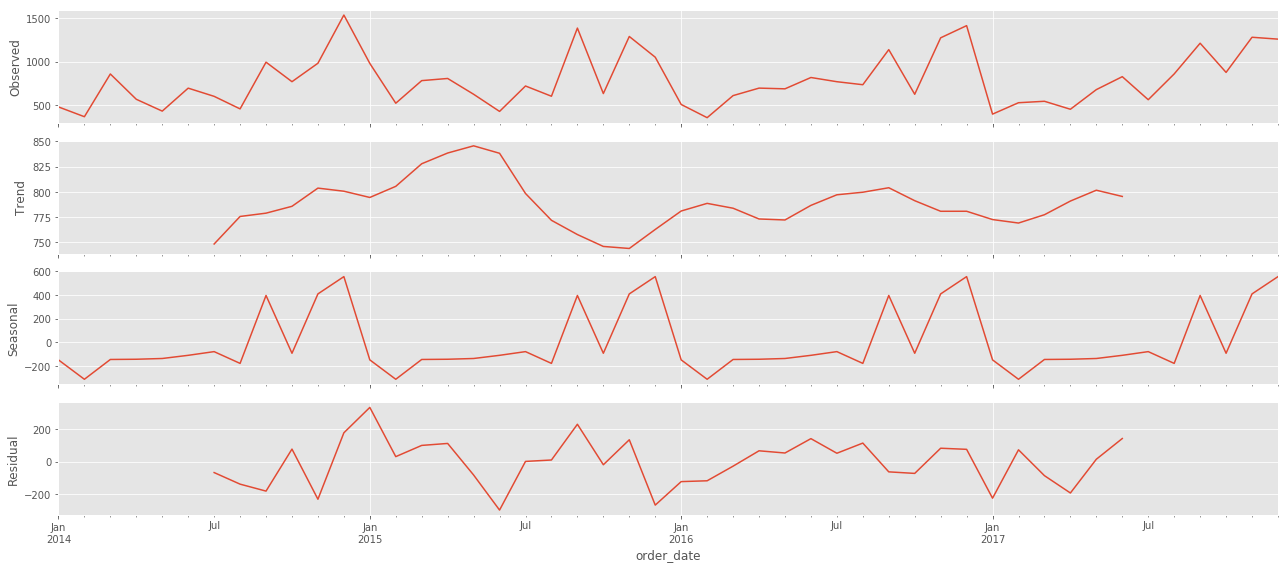

In [76]:
#Furniture time-series decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(avg_furniture_sales, model='additive')
fig = decomposition.plot()
plt.show()

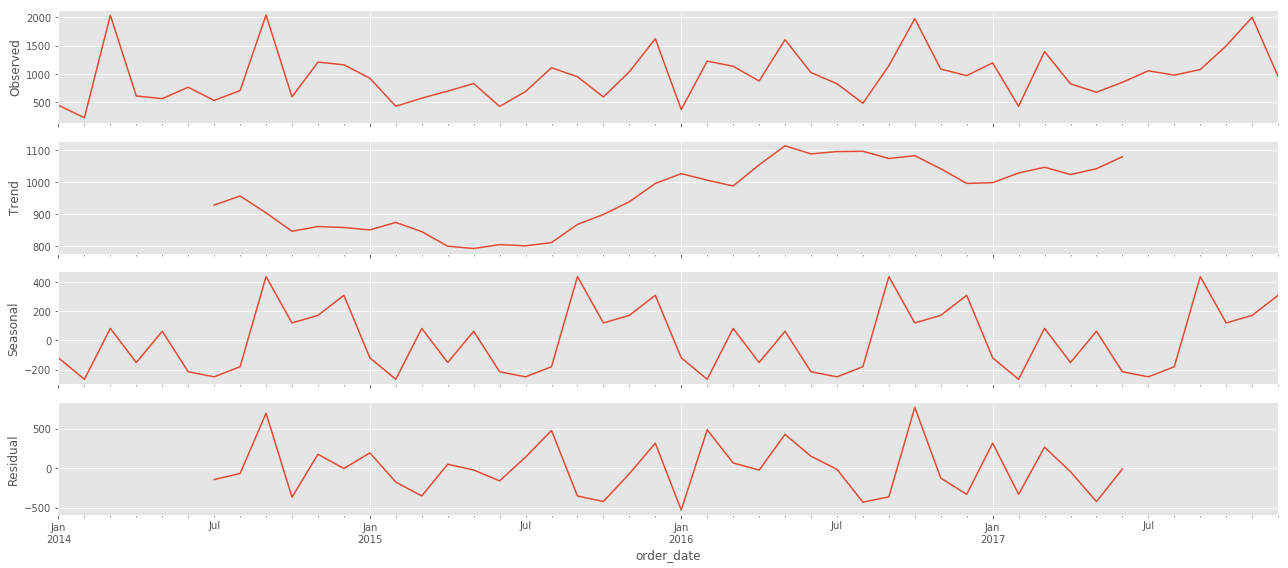

In [77]:
#Technology time-series decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(avg_technology_sales, model='additive')
fig = decomposition.plot()
plt.show()

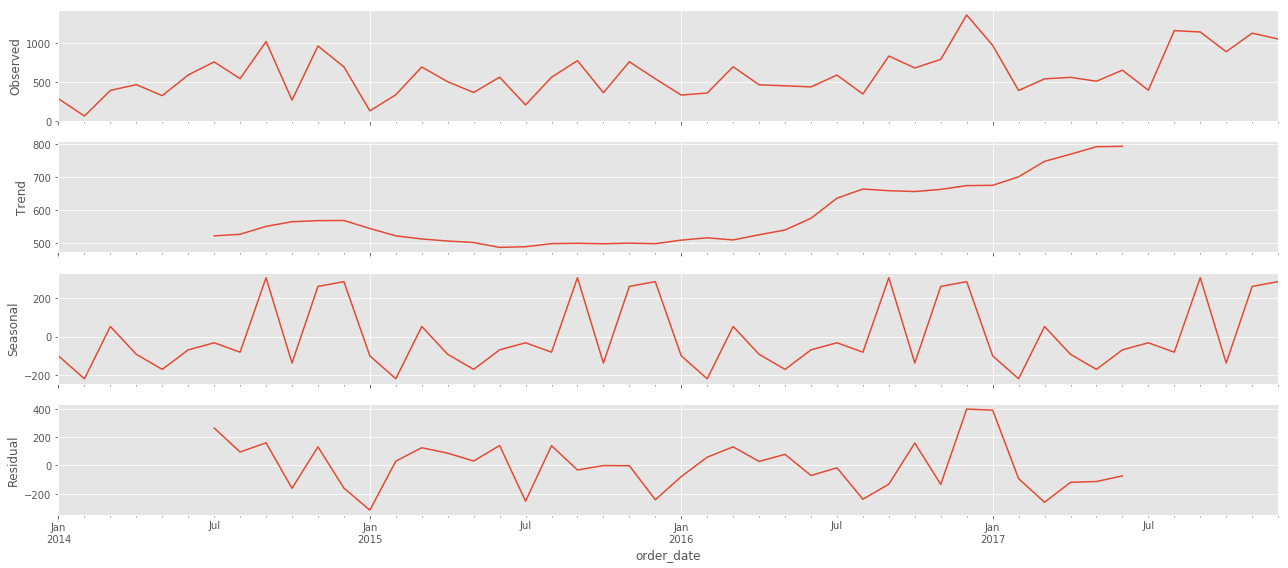

In [78]:
#Office supplies time-series decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(avg_office_sales, model='additive')
fig = decomposition.plot()
plt.show()